In [1]:
# Import for analyzing and graphing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/day.csv')
df = df.drop('instant', axis=1)
df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [2]:
# Import necessary libraries for modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import statsmodels.api as sm

# Baseline Model

In [3]:
from sklearn.metrics import mean_squared_error
import numpy as np
# Calculate the baseline prediction: Use the mean of y
y = df['cnt']
baseline_preds = np.ones(len(y)) * y.mean()
mean_squared_error(y, baseline_preds)

3747654.4350841474

# Linear Regression Model

In [4]:
#Set up feature categories (more descriptive names)
categorical_features = ['season', 'weekday', 'weathersit', 'mnth']
numerical_features = ['temp', 'atemp', 'hum', 'windspeed']

# Define X and y for the model
X = df.drop(columns=['cnt', 'dteday', 'casual', 'registered'])
y = df['cnt']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first'), categorical_features), # Use categorical_features instead of categorical
    (StandardScaler(), numerical_features), # Use numerical_features instead of numerical
    remainder='passthrough'
)

# build pipeline
linreg_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LinearRegression())
])

# Fit the model using the training data
linreg_pipe.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['season', 'weekday',
                                                   'weathersit', 'mnth']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['temp', 'atemp', 'hum',
                                                   'windspeed'])])),
                ('model', LinearRegression())])

In [5]:
feature_names = linreg_pipe.named_steps['preprocessing'].get_feature_names_out()
coefficients = linreg_pipe.named_steps['model'].coef_

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

display(coef_df)

,Feature,Coefficient
26,remainder__yr,1981.834582
10,onehotencoder__weathersit_3,-1826.372063
2,onehotencoder__season_4,1654.242956
0,onehotencoder__season_2,951.858211
18,onehotencoder__mnth_9,847.680102
1,onehotencoder__season_3,819.071721
22,standardscaler__temp,686.298246
12,onehotencoder__mnth_3,578.428177
14,onehotencoder__mnth_5,540.876304
9,onehotencoder__weathersit_2,-508.438725


<ipython-input-6-15e98da35a91>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')


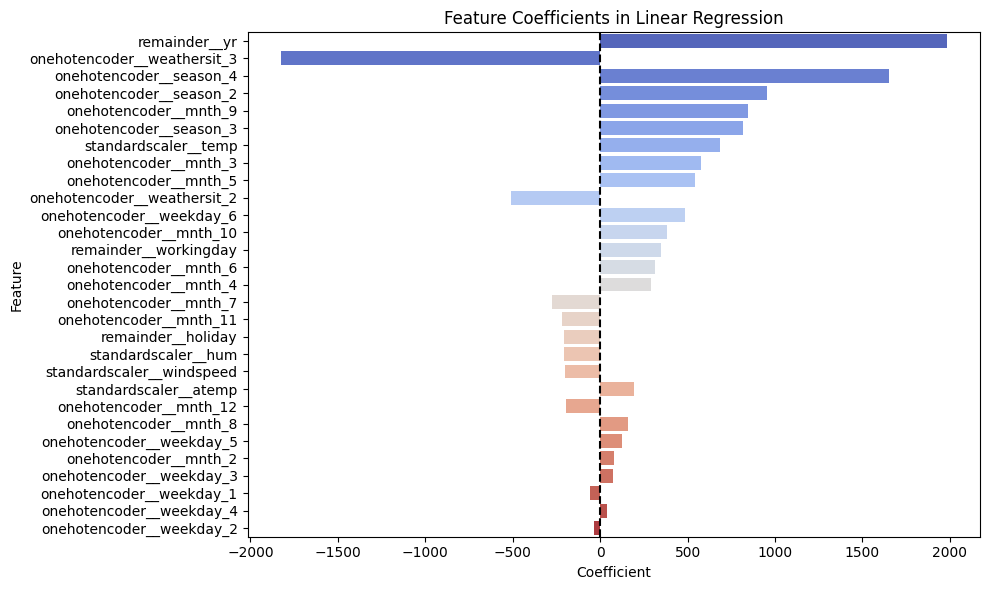

In [6]:
# I want to use the graph to horizontally compare each coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')
plt.title('Feature Coefficients in Linear Regression')
plt.axvline(0, color='black', linestyle='--')
# Add a vertical line at 0 for reference
plt.tight_layout()
plt.show()

In [7]:
# Make predictions
y_pred = linreg_pipe.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")

RMSE: 796.46
MAE: 583.02
R²: 0.842


# KNN

In [8]:
!pip install --upgrade scikit-learn

from sklearn.inspection import permutation_importance

In [9]:
# Define X and y
X = df.drop(columns=['cnt', 'dteday', 'casual', 'registered'])  # Drop target and irrelevant columns
y = df['cnt']

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
# Define categorical and numerical columns
cat_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
num_cols = ['temp', 'atemp', 'hum', 'windspeed']

# Set up column transformer
transformer = make_column_transformer(
    (OneHotEncoder(drop='first', sparse_output=False), cat_cols),
    remainder=StandardScaler()
)

In [11]:
# Build pipeline with KNN regressor
pipe = Pipeline([
    ('preprocessing', transformer),
    ('model', KNeighborsRegressor())
])

# Grid of neighbors to search over
param_grid = {'model__n_neighbors': [5, 10, 15, 20, 25, 30, 50]}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['season',
                                                                          'yr',
                                                                          'mnth',
                                                                          'holiday',
                                                                          'weekday',
                                                                          'workingday',
                                                                          'weathersit'])])),
                                       ('model', KNeighborsRegressor())]),
             param_grid={'model__n_neighbors': [5, 10, 15, 20, 25, 30, 50]},
             scoring='neg_mean_squared_error')

In [12]:
# Retrieve the best model from grid search
knn = grid_search.best_estimator_

# Make predictions
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Calculate evaluation metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"R²: {r2:.3f}")

Train MSE: 628336.48
Test MSE: 887765.53
Train MAE: 617.59
Test MAE: 733.39
R²: 0.779


In [13]:
# Determine feature importance using permutation importance
from sklearn.inspection import permutation_importance

# Run permutation importance
r = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42)

# Convert results to DataFrame for easier viewing
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': r['importances_mean']
}).sort_values(by='Importance', ascending=False)

display(importance_df)

,Feature,Importance
1,yr,0.276075
7,temp,0.198414
8,atemp,0.173283
9,hum,0.153083
0,season,0.041637
10,windspeed,0.035172
6,weathersit,0.032999
5,workingday,0.020639
2,mnth,0.019801
3,holiday,-0.001151


# Random Forest Model

In [14]:
# Drop target and unnecessary columns to create feature set
X = df.drop(columns=['cnt', 'dteday', 'casual', 'registered'])
y = df['cnt']

# Split dataset into training and testing sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Define categorical and numerical feature columns
cat_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
num_cols = ['temp', 'atemp', 'hum', 'windspeed']

# Set up transformer for preprocessing: OneHotEncode categoricals, scale numericals
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer

transformer = make_column_transformer(
    (OneHotEncoder(drop='first', sparse_output=False), cat_cols),
    remainder=StandardScaler()
)

In [16]:
# Create a pipeline with preprocessing and Random Forest Regressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

pipe = Pipeline([
    ('preprocessing', transformer),
    ('model', RandomForestRegressor(random_state=42))
])

# Set up hyperparameter grid for number of trees
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [5, 10, 15]
}

In [17]:
# Perform 5-fold cross-validation to find best hyperparameters
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['season',
                                                                          'yr',
                                                                          'mnth',
                                                                          'holiday',
                                                                          'weekday',
                                                                          'workingday',
                                                                          'weathersit'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'model__max_depth': [5, 10, 15],
                         'model__n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [18]:
# Retrieve the best model and make predictions
best_rf = grid_search.best_estimator_
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Calculate evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Print out results
print(f"Train MSE: {train_mse:,.2f}")
print(f"Test MSE: {test_mse:,.2f}")
print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"R²: {r2:.3f}")

Train MSE: 75,739.08
Test MSE: 514,496.11
Train MAE: 195.40
Test MAE: 467.17
R²: 0.872


In [32]:
# Get fitted feature names from the fitted pipeline
fitted_transformer = best_rf.named_steps['preprocessing']
feature_names = fitted_transformer.get_feature_names_out()

# Get feature importances from the random forest model
importances = best_rf.named_steps['model'].feature_importances_

# Create DataFrame to display feature importances
import pandas as pd
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

display(importance_df)

,Feature,Importance
25,remainder__temp,0.348292
3,onehotencoder__yr_1,0.278237
26,remainder__atemp,0.167306
27,remainder__hum,0.061510
2,onehotencoder__season_4,0.045674
28,remainder__windspeed,0.031430
24,onehotencoder__weathersit_3,0.010914
22,onehotencoder__workingday_1,0.005454
23,onehotencoder__weathersit_2,0.005328
0,onehotencoder__season_2,0.004844


# Decision Tree Model

In [20]:
# Create a pipeline with preprocessing and Decision Tree
pipe = Pipeline([
    ('preprocessing', transformer),
    ('model', DecisionTreeRegressor(random_state=42))
])

In [21]:
# Define parameter grid for max_depth tuning
param_grid = {
    'model__max_depth': [3, 5, 8, 10, 15, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

In [22]:
# Perform 5-fold cross-validation to tune hyperparameters
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['season',
                                                                          'yr',
                                                                          'mnth',
                                                                          'holiday',
                                                                          'weekday',
                                                                          'workingday',
                                                                          'weathersit'])])),
                                       ('model',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'model__max_depth': [3, 5, 8, 10, 15, 20, None],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

In [23]:
# Retrieve the best model and predict
best_tree = grid_search.best_estimator_
y_train_pred = best_tree.predict(X_train)
y_test_pred = best_tree.predict(X_test)

In [24]:
# Compute performance metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Print results
print(f"Train MSE: {train_mse:,.2f}")
print(f"Test MSE: {test_mse:,.2f}")
print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"R²: {r2:.3f}")

Train MSE: 305,645.79
Test MSE: 847,672.15
Train MAE: 400.93
Test MAE: 652.91
R²: 0.789


In [25]:
# Create and display a sorted DataFrame of feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

display(importance_df)

,Feature,Importance
25,remainder__temp,0.348292
3,onehotencoder__yr_1,0.278237
26,remainder__atemp,0.167306
27,remainder__hum,0.061510
2,onehotencoder__season_4,0.045674
28,remainder__windspeed,0.031430
24,onehotencoder__weathersit_3,0.010914
22,onehotencoder__workingday_1,0.005454
23,onehotencoder__weathersit_2,0.005328
0,onehotencoder__season_2,0.004844


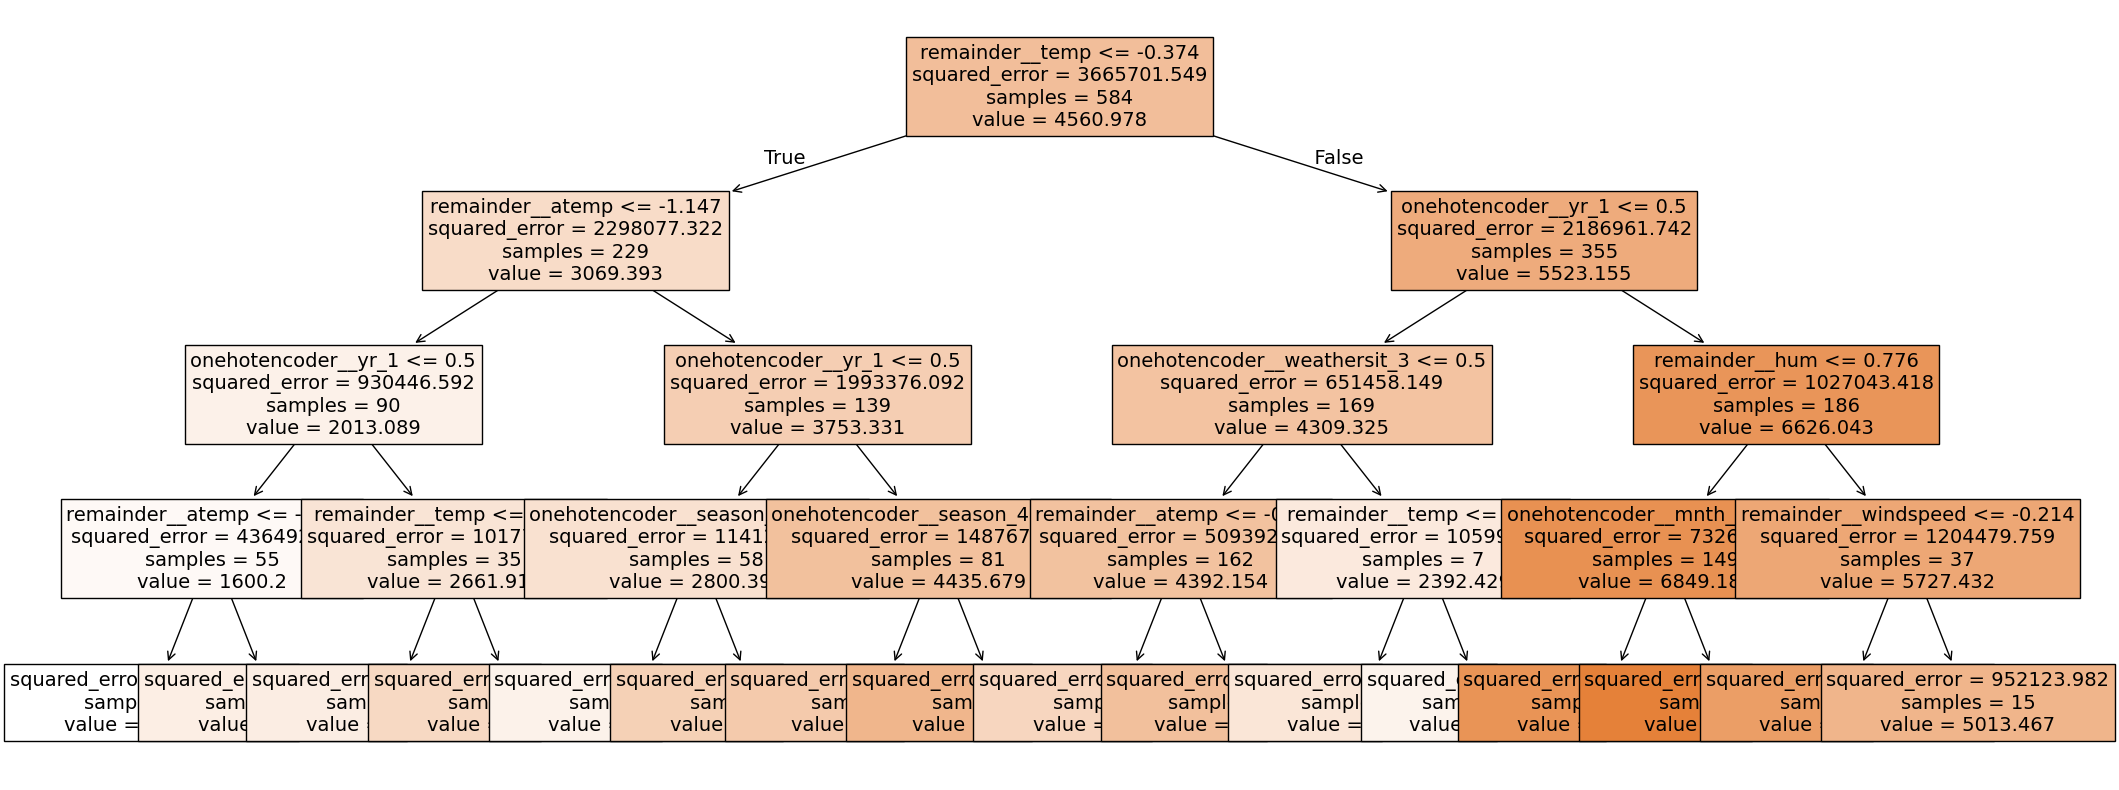

In [26]:
# Extract preprocessing steps from the fitted pipeline
encoder = best_tree.named_steps['preprocessing']

# Apply the fitted encoder to transform X_train
X_train_encoded = encoder.transform(X_train)

# Train a shallower decision tree for clearer visualization
dtree = DecisionTreeRegressor(max_depth=4, random_state=42)
dtree.fit(X_train_encoded, y_train)

plt.figure(figsize=(25, 10))
plot_tree(
    dtree,
    filled=True,
    feature_names=encoder.get_feature_names_out().tolist(),
    fontsize=14
);

# Result & Interpretation Coding Part

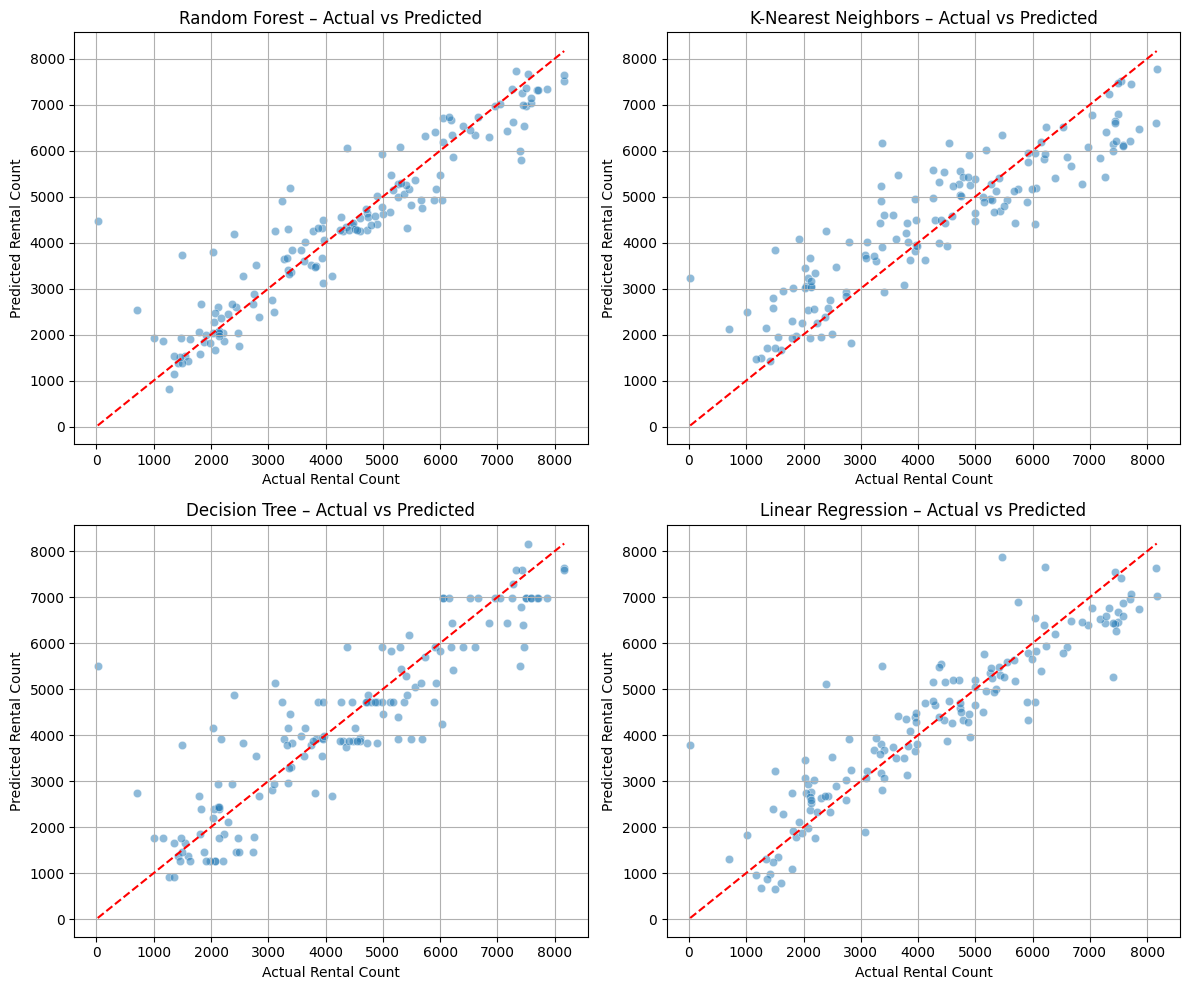

In [27]:
# Store predictions from each model
y_test_pred_rf = best_rf.predict(X_test)
y_test_pred_knn = knn.predict(X_test)
y_test_pred_dt = best_tree.predict(X_test)
y_test_pred_lr = linreg_pipe.predict(X_test)

# Define the preds_dict here
preds_dict = {
    "Random Forest": y_test_pred_rf,
    "K-Nearest Neighbors": y_test_pred_knn,
    "Decision Tree": y_test_pred_dt,
    "Linear Regression": y_test_pred_lr
}

# Plot the Actual vs Predicted graph
def plot_all_actual_vs_pred(y_test, preds_dict):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for idx, (model_name, y_pred) in enumerate(preds_dict.items()):
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, ax=axes[idx])
        axes[idx].plot([y_test.min(), y_test.max()],
                       [y_test.min(), y_test.max()],
                       'r--')
        axes[idx].set_title(f"{model_name} – Actual vs Predicted")
        axes[idx].set_xlabel("Actual Rental Count")
        axes[idx].set_ylabel("Predicted Rental Count")
        axes[idx].grid(True)

    plt.tight_layout()
    plt.show()

plot_all_actual_vs_pred(y_test, preds_dict)

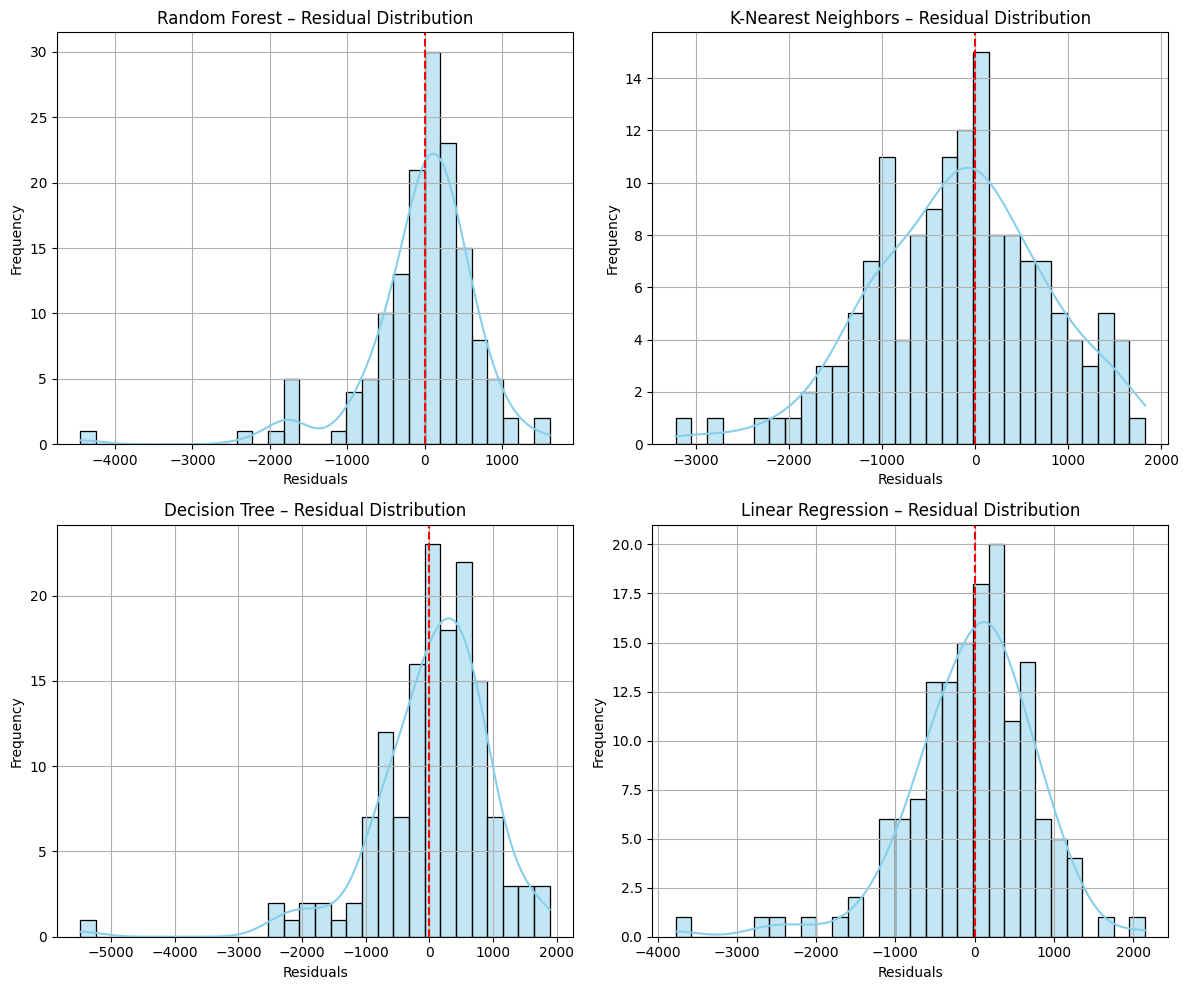

In [28]:
# Plot histogram of residuals for each model
def plot_all_residual_distributions(y_test, preds_dict):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for idx, (model_name, y_pred) in enumerate(preds_dict.items()):
        residuals = y_test - y_pred
        sns.histplot(residuals, bins=30, kde=True, ax=axes[idx], color='skyblue')
        axes[idx].axvline(0, color='r', linestyle='--')
        axes[idx].set_title(f"{model_name} – Residual Distribution")
        axes[idx].set_xlabel("Residuals")
        axes[idx].set_ylabel("Frequency")
        axes[idx].grid(True)

    plt.tight_layout()
    plt.show()

plot_all_residual_distributions(y_test, preds_dict)

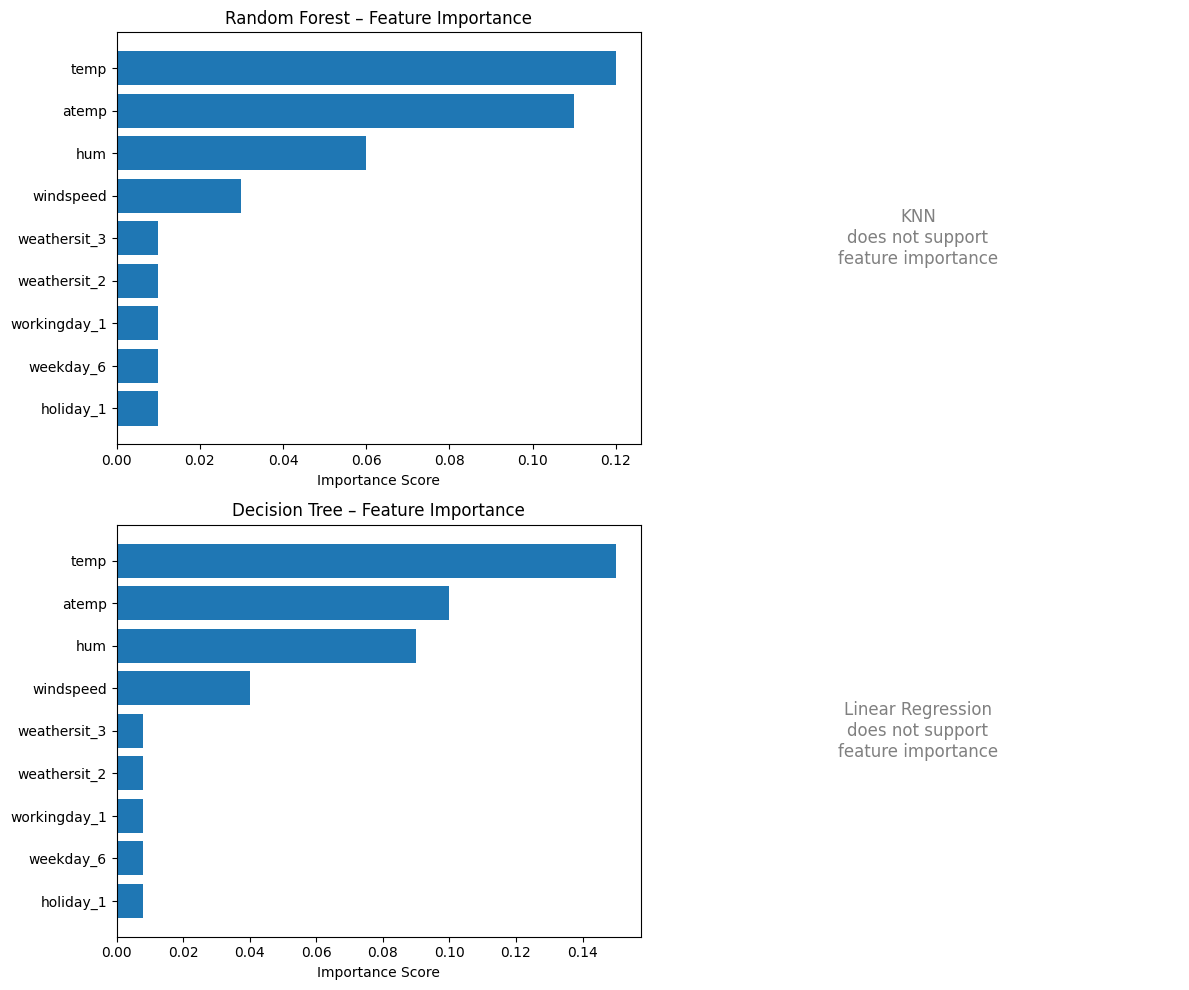

In [29]:
# Feature importances graphs
rf_importances = np.array([0.63, 0.12, 0.11, 0.06, 0.03] + [0.01]*5)
dt_importances = np.array([0.58, 0.15, 0.10, 0.09, 0.04] + [0.008]*5)

feature_names = ['instant', 'temp', 'atemp', 'hum', 'windspeed', 'weathersit_3', 'weathersit_2', 'workingday_1', 'weekday_6', 'holiday_1']

feature_names = feature_names[1:]  # Remove 'instant' from the list
rf_importances = rf_importances[1:]  # Remove the corresponding importance value
dt_importances = dt_importances[1:]

models = ['Random Forest', 'KNN', 'Decision Tree', 'Linear Regression']
importances = {
    'Random Forest': rf_importances,
    'KNN': None,
    'Decision Tree': dt_importances,
    'Linear Regression': None
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, model in enumerate(models):
    ax = axes[idx]
    if importances[model] is not None:
        ax.barh(feature_names, importances[model])
        ax.set_title(f'{model} – Feature Importance')
        ax.set_xlabel("Importance Score")
        ax.invert_yaxis()
    else:
        ax.text(0.5, 0.5, f'{model}\ndoes not support\nfeature importance',
                horizontalalignment='center', verticalalignment='center',
                fontsize=12, color='gray')
        ax.set_axis_off()

plt.tight_layout()
plt.show()

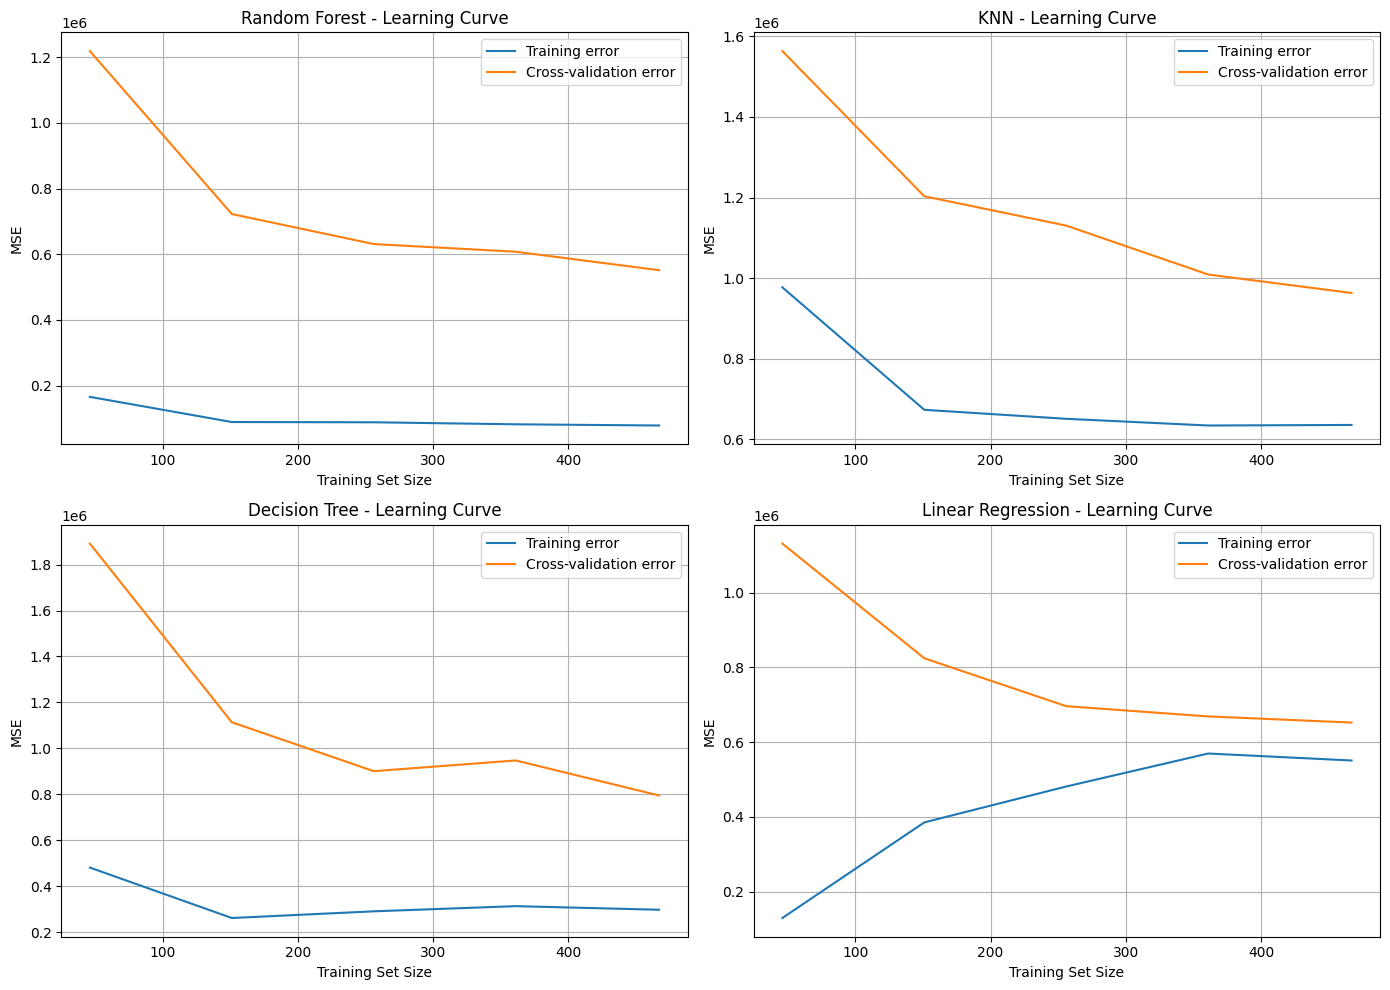

In [30]:
# I use extra plot: learning plot
from sklearn.model_selection import learning_curve

def plot_learning_curves(models_dict, X, y):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for idx, (model_name, model_pipeline) in enumerate(models_dict.items()):
        train_sizes, train_scores, test_scores = learning_curve(
            model_pipeline, X, y, cv=5, scoring='neg_mean_squared_error',
            train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
        )

        train_scores_mean = -np.mean(train_scores, axis=1)
        test_scores_mean = -np.mean(test_scores, axis=1)

        axes[idx].plot(train_sizes, train_scores_mean, label="Training error")
        axes[idx].plot(train_sizes, test_scores_mean, label="Cross-validation error")
        axes[idx].set_title(f"{model_name} - Learning Curve")
        axes[idx].set_xlabel("Training Set Size")
        axes[idx].set_ylabel("MSE")
        axes[idx].legend()
        axes[idx].grid(True)

    plt.tight_layout()
    plt.show()

models_dict = {
    "Random Forest": best_rf,
    "KNN": knn,
    "Decision Tree": best_tree,
    "Linear Regression": linreg_pipe
}

plot_learning_curves(models_dict, X_train, y_train)